In [2]:
import xarray as xr
import numpy as np
import tools
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from datetime import datetime 
from datetime import timedelta

import scipy.interpolate as interp

scrip.so not found. Remapping function will not be available


# Assessment of the OSSE simulations

An assesment of the OSSE simulations will be done here. We will try to perform it in a analogue way to the one done for the OSE, where real observations were used for assimilation and assesment.

- SLA: The value of the NR at the position of the regular satellite tracks will be extracted and compared to the simulations.
    
- SST: The NR surface temperature field will be considered and subsampled, reducing the resolution to 10 km by picking one of every four observations both in vertical and horizontal.
    
- ARGO: Temperature and salinity profiles at position of the buoys during the experiment will be extracted from NR and simulations and compared
    
- TS profiles will algo be assesed in areas of the domain distant from assimialt4ed observations. This way, the capabilities of the model will also be assesed.

- HFR: The data samples taken apart for validation will be used for this purpose

## HFR

#### Load Observations



In [3]:
obs_path = '/DATA/jhernandez/WMOP_ASSIM/Observations/HFR_OSSE/hfr_validation_2/'
obsfile = glob(obs_path + '*HFR*future_val*')   # virtual Obs
obsfile.sort()

In [4]:
path = '/DATA/jhernandez/WMOP_ASSIM/Outputs/HFR_all_actual_nudging_Oct2014_OSSE/20140923/'
inn_file = glob(path + 'inn*')[0]
obs_file = glob(path + 'obs*')[0]

In [5]:
def get_innovations(inn_file, obs_file):
    """Load innovation and observations files as
    pandas dataframes and merge them together"""
    
    # Load innovation and observations
    inn = pd.read_csv(inn_file, delimiter=' ', header=None, skiprows=[0], names = ['obs_nb', 'obs_lon', 'obs_lat', 'obs_depth', 'obs_value', 'obs_err', 'obs_noise', 'innovation', 'reg_coeff', 'increment', 'analysis', 'background', 'bg_err_variance'], index_col=[0])
    obs = pd.read_csv(obs_file, delimiter=' ', header=None, index_col=[1], names=['sync', 'source', 'nb_sou', 'year', 'month', 'day', 'hour', 'minute', 'lon', 'lat', 'depth', 'value', 'err', 'rep'])

    # Create index to merge through
    inn['merge_ind']=inn.index
    obs['merge_ind']=obs.index

    # Merge datadrames and drop repeated fields
    df = inn.merge(obs,how='outer', on='merge_ind')
    df = df.drop(['lon', 'lat', 'depth', 'value', 'err', 'rep', 'merge_ind', 'sync'], axis=1)
    
    return df

In [6]:
df = get_innovations(inn_file, obs_file)

(array([ 31.,  67.,  51., 231., 423., 313., 147.,  56.,  20.,  26.]),
 array([-0.3057 , -0.23735, -0.169  , -0.10065, -0.0323 ,  0.03605,
         0.1044 ,  0.17275,  0.2411 ,  0.30945,  0.3778 ]),
 <a list of 10 Patch objects>)

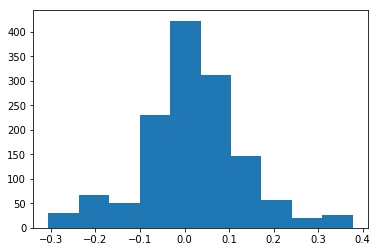

In [11]:
plt.hist(df_hfr['increment'])

In [17]:
import skill_metrics as sm

In [19]:
# Define initial and end date
date_ini = datetime(2014,9,20)
date_end = datetime(2014,10,22)

rmsd_u = {}
rmsd_v = {}
rmsd_u_bg = {}
rmsd_v_bg = {}

# Experiment names from which to extract equivalents to observations and to calculate RMSD
exp_names = ['all_future_nudging', 'all_actual_nudging', 'all_future_nonudging', 'all_actual_nonudging']

# number of days of simulation
ndays = (date_end - date_ini).days

# Loop over different simulations
for exp in exp_names:
    
    date = date_ini
    rmsd_u[exp] = []
    rmsd_v[exp] = []
    rmsd_u_bg[exp] = []
    rmsd_v_bg[exp] = []
    
    # Loop over days
    for i in range(ndays//3):
        strdate = date.strftime('%Y%m%d')

        path = '/DATA/jhernandez/WMOP_ASSIM/Outputs/HFR_{0}_Oct2014_OSSE/{1}/'.format( exp, strdate)
        inn_file = glob(path + 'inn*')[0]
        obs_file = glob(path + 'obs*')[0]
        
        df = get_innovations(inn_file, obs_file)
        #print('Number obs loaded = {0}'.format(len(df)))
        
        df_u = df[(df['source']=='HF_Radar') & (df['nb_sou']==3) ].reset_index(drop=True)
        df_v = df[(df['source']=='HF_Radar') & (df['nb_sou']==4)].reset_index(drop=True)

       # rmsd_u[exp].append( np.sqrt(np.nansum(np.square( (df_u['analysis'] - df_u['obs_value']) ))/len(df_u)) )
       # rmsd_v[exp].append( np.sqrt(np.nansum(np.square( (df_v['analysis'] - df_v['obs_value']) ))/len(df_v)) )
        
       # rmsd_u_bg[exp].append( np.sqrt(np.nansum(np.square( (df_u['background'] - df_u['obs_value']) ))/len(df_u)) )
       # rmsd_v_bg[exp].append( np.sqrt(np.nansum(np.square( (df_v['background'] - df_v['obs_value']) ))/len(df_v)) )
        
        rmsd_u[exp].append( sm.rmsd(df_u['analysis'], df_u['obs_value']) )
        rmsd_v[exp].append( sm.rmsd(df_v['analysis'], df_v['obs_value']) )
        
        rmsd_u_bg[exp].append( sm.rmsd(df_u['background'], df_u['obs_value']) )
        rmsd_v_bg[exp].append( sm.rmsd(df_v['background'], df_v['obs_value']) )
        
        
        
        date = date + timedelta(days=3)
        
    print('RMSD for {0} calculated'.format(exp))

RMSD for all_future_nudging calculated
RMSD for all_actual_nudging calculated
RMSD for all_future_nonudging calculated
RMSD for all_actual_nonudging calculated


In [12]:
t0 = datetime(2014,9,20)
t = [t0 + timedelta(days=i) for i in range(0,33,3)]
xt = range(0,31,3)
tt = [time.strftime('%d/%m/%Y') for time in t]

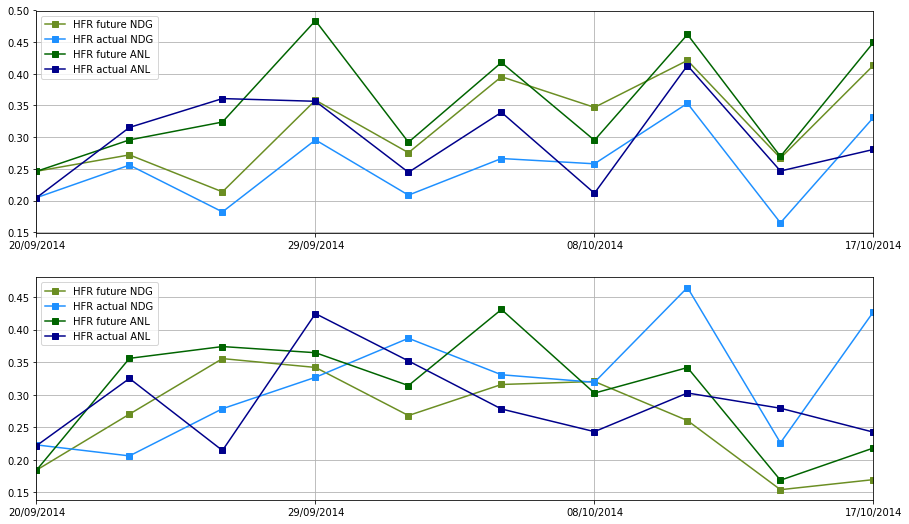

In [20]:
exp_names = ['all_future_nudging', 'all_actual_nudging', 'all_future_nonudging', 'all_actual_nonudging']
colors = ['olivedrab',  'dodgerblue', 'darkgreen', 'darkblue', 'salmon', 'darkred']


plt.figure(figsize=(15,9))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

# Loop over different simulations
for i, exp in enumerate(exp_names):
    
    ax1.plot(np.array(rmsd_u[exp]) / np.array(rmsd_u_bg[exp]), marker='s', linestyle='-', color=colors[i] )
    ax2.plot(np.array(rmsd_v[exp]) / np.array(rmsd_v_bg[exp]), marker='s', linestyle='-', color=colors[i] )
ax1.legend(['HFR future NDG', 'HFR actual NDG','HFR future ANL', 'HFR actual ANL' ])
ax2.legend(['HFR future NDG', 'HFR actual NDG', 'HFR future ANL', 'HFR actual ANL'])

ax1.grid(True)
ax1.set_xticks(ticks=list(xt))
ax1.set_xticklabels(labels=tt[0:-1:3])
ax1.set_xlim((0,9))

ax2.grid(True)
ax2.set_xticks(ticks=list(xt))
ax2.set_xticklabels(labels=tt[0:-1:3])
plt.xlim((0,9))

plt.show()

In [ ]:
rmsd_u_bg

In [ ]:
-(dd['background'] - dd['analysis'])

In [ ]:
dd['obs_value']- dd['background']

## Check a date field

In [ ]:
date = datetime(2014,10,8)
strdate = date.strftime('%Y%m%d')

path = '/DATA/jhernandez/WMOP_ASSIM/Outputs/HFR_{0}_Oct2014_OSSE/{1}/'.format( exp, strdate)
inn_file = glob(path + 'inn*')[0]
obs_file = glob(path + 'obs*')[0]

df = get_innovations(inn_file, obs_file)
#print('Number obs loaded = {0}'.format(len(df)))

df_u = df[(df['source']=='HF_Radar') & (df['nb_sou']==3) ].reset_index(drop=True)
df_v = df[(df['source']=='HF_Radar') & (df['nb_sou']==4)].reset_index(drop=True)

In [ ]:

plt.figure(figsize=(15,5))

ax, gl = tools.make_map(continents=False, limits=[0, 1.8, 38.2, 39.2], subplot_dim=121)
plt.scatter(df_u.obs_lon, df_u.obs_lat, 30, df_u.obs_value, transform=gl.crs, cmap='RdBu_r', vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title('U')